In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

import MicroTools as micro
import MicroTools.plot_tools as pt

import MicroTools.param_scan as param_scan
from tqdm.notebook import tqdm

In [20]:
from scipy.stats import chi2
levels_sigmas_2dof = [chi2.ppf(0.682689492137086, 2), chi2.ppf(0.954499736103642, 2), chi2.ppf(0.997300203936740, 2), chi2.ppf(0.999936657516334, 2)]
levels_sigmas_3dof = [chi2.ppf(0.682689492137086, 3), chi2.ppf(0.954499736103642, 3), chi2.ppf(0.997300203936740, 3), chi2.ppf(0.999936657516334, 3)]
level_95CL_2dof = [chi2.ppf(0.95, 2)]
level_95CL_3dof = [chi2.ppf(0.95, 3)]

# Context

When using the numu disappearance sample there are 2 choices:
1) is the fit using the recent numu MC provided by MiniBooNE or using the recoEnu spectrum?
2) is the fit assuming that the numu normalization is fixed or undone by 1/Pmumu?

Our baseline choice for the paper is "numu_MC_keep_numu_norm"

MH_numu_MC_undo_numu_norm
MH_numu_MC_keep_numu_norm
MH_numu_reco_undo_numu_norm
MH_numu_reco_keep_numu_norm

# 3+1 Oscillations Scans

In [3]:
def run_scan_osc_only(kwargs, filename, Npoints=10, path_results = "fit_data/", sin2theta_scan=False):

    # Range of mixings scanned 
    dm_Vec = np.geomspace(np.sqrt(1e-2), np.sqrt(100), Npoints)

    if sin2theta_scan:
        s2thetaSq = np.geomspace(1e-4, 0.5, Npoints)
        Umu4Sq = 0.5
        # Cartesian product of grid -- already imposes unitarity and pertubatirbity of g
        paramlist = param_scan.create_grid_of_params_sin2theta(g=1e-10, m4=dm_Vec, sin2thetaSq=s2thetaSq, Um4Sq=Umu4Sq)
        
    else:
        Ue4Sq = np.geomspace(1e-3, 0.5, Npoints)
        Umu4Sq = np.geomspace(1e-3, 0.5, Npoints)
        # Cartesian product of grid -- already imposes unitarity and pertubatirbity of g
        paramlist = param_scan.create_grid_of_params(g=1e-10, m4=dm_Vec, Ue4Sq=Ue4Sq, Um4Sq=Umu4Sq)

    # Pure oscillation method
    func_scan = partial(param_scan.DecayReturnMicroBooNEChi2, **kwargs)

    with Pool() as pool:
        # res = pool.map(func_scan, paramlist)
        res = np.array(list(tqdm(pool.imap(func_scan, paramlist), total=len(paramlist))))

    param_scan.write_pickle(f"{path_results}/{filename}", res)
    return res

In [4]:
# Common attributes to all osc_only scans
kwargs_common = {
    'oscillations': True, 
    'decay': False, 
    'decouple_decay': True, 
    'energy_degradation': False, 
    'include_antineutrinos': True, 
    'n_replications': 1}

# Appearance only
kwargs_apponly = {
    'disappearance': False, 
    'use_numu_MC': False,
    'undo_numu_normalization': False,
    **kwargs_common}

# Full and Standard case
kwargs_std_numu_MC_undo_numu_norm = {
    'disappearance': True, 
    'use_numu_MC': True,
    'undo_numu_normalization': True,
    **kwargs_common}

kwargs_std_numu_MC_keep_numu_norm = {
    'disappearance': True, 
    'use_numu_MC': True,
    'undo_numu_normalization': False,
    **kwargs_common}

kwargs_std_numu_reco_undo_numu_norm = {
    'disappearance': True, 
    'use_numu_MC': False,
    'undo_numu_normalization': True,
    **kwargs_common}

kwargs_std_numu_reco_keep_numu_norm = {
    'disappearance': True, 
    'use_numu_MC': False,
    'undo_numu_normalization': False,
    **kwargs_common}


In [5]:
PERFORM_SCAN = False

if PERFORM_SCAN:
    n = 50
    _ = run_scan_osc_only(kwargs_apponly, f'MH_apponly_{n}', sin2theta_scan=True, Npoints=n)
    _ = run_scan_osc_only(kwargs_std_numu_MC_undo_numu_norm, 'MH_numu_MC_undo_numu_norm', Npoints=n)
    _ = run_scan_osc_only(kwargs_std_numu_MC_keep_numu_norm, 'MH_numu_MC_keep_numu_norm', Npoints=n)
    _ = run_scan_osc_only(kwargs_std_numu_reco_undo_numu_norm, 'MH_numu_reco_undo_numu_norm', Npoints=n)
    _ = run_scan_osc_only(kwargs_std_numu_reco_keep_numu_norm, 'MH_numu_reco_keep_numu_norm', Npoints=n)


In [6]:
def load_scan_data(filename):
    data = param_scan.pickle_read(filename)
    
    data_dic = {}
    data_dic['Ue4SQR'] = data[:,2]
    data_dic['Umu4SQR'] = data[:,3]
    s2t = 4*data_dic['Ue4SQR']*data_dic['Umu4SQR']
    data_dic['sin2theta'] = np.round(s2t, decimals=6)
    data_dic['dm4SQR'] = data[:,1]**2
    
    data_dic['MiniApp_chi2'] =  data[:,-3]
    data_dic['MicroApp_chi2'] =  data[:,-2]
    data_dic['MicroApp_Asimov_chi2'] = data[:,-1] 

    data_dic['MiniApp_deltachi2'] = data_dic['MiniApp_chi2'] - np.min(data_dic['MiniApp_chi2'])
    data_dic['MicroApp_deltachi2'] = data_dic['MicroApp_chi2'] - np.min(data_dic['MicroApp_chi2'])
    data_dic['MicroApp_Asimov_deltachi2'] = data_dic['MicroApp_Asimov_chi2'] - np.min(data_dic['MicroApp_Asimov_chi2'])

    return data_dic


In [7]:
def profile_for_sin2theta(data_dic):
    dic_prof = {}
    # Profile each chi2
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MiniApp_deltachi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MiniApp_deltachi2'])
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MicroApp_deltachi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MicroApp_deltachi2'])
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MicroApp_Asimov_deltachi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MicroApp_Asimov_deltachi2'])
    return dic_prof

In [8]:
def draw_miniboone_contour(ax):
    # Official MiniBooNE contours 
    dm2, sin2, chi2 = np.genfromtxt('MiniTools/include/MB_data_release_2020/combined/likihood_surface_contNunubar.txt').T


    kwargs_interp = {'fine_gridx': len(np.unique(sin2)),  
                            'fine_gridy': len(np.unique(dm2)), 
                            'logx':True, 
                            'logy':True,
                            }

    X, Y, Z = pt.interp_grid(sin2, dm2, chi2 - chi2.min(), **kwargs_interp)
    ax = plt.contour(X,Y,Z, levels=[0, 11.83, 19.33], colors=['black','black'], zorder=1, alpha=1, linestyles=[(1,(1,0)), (1,(3,1))])

In [13]:
dic_app = profile_for_sin2theta(load_scan_data('fit_data/MH_apponly_50.pkl'))
dic_fullosc = profile_for_sin2theta(load_scan_data('fit_data/MH_fullosc_3D_50.pkl'))
dic_numu_MC_undo_numu_norm = profile_for_sin2theta(load_scan_data('fit_data/fits_before_May6/MH_numu_MC_undo_numu_norm.pkl'))
dic_numu_MC_keep_numu_norm = profile_for_sin2theta(load_scan_data('fit_data/fits_before_May6/MH_numu_MC_keep_numu_norm.pkl'))
dic_numu_reco_undo_numu_norm = profile_for_sin2theta(load_scan_data('fit_data/fits_before_May6/MH_numu_reco_undo_numu_norm.pkl'))
dic_numu_reco_keep_numu_norm = profile_for_sin2theta(load_scan_data('fit_data/fits_before_May6/MH_numu_reco_keep_numu_norm.pkl'))

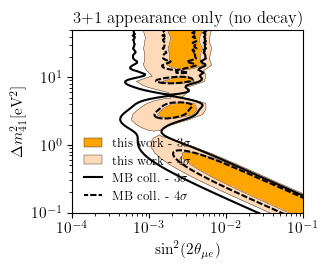

In [14]:
app_dic = load_scan_data('fit_data/MH_apponly_50.pkl')
app_dic = profile_for_sin2theta(app_dic)
f = [0.18, 0.16, 0.77, 0.76]
fig, ax1 = pt.std_fig(figsize=(3, 2.4), ax_form=f)
xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)

kwargs_interp = {'fine_gridx': len(np.unique(app_dic['sin2theta'])),  
                'fine_gridy': len(np.unique(app_dic['dm4SQR'])), 
                'logx':True, 
                'logy':True,
                }

levsMicroB = [11.83]
X, Y, Z = pt.interp_grid(app_dic['sin2theta'], app_dic['dm4SQR'], app_dic['MiniApp_deltachi2'], **kwargs_interp)
cs = ax1.contourf(X,Y,Z, levels=[0, 11.83, 19.33], colors=['orange','peachpuff'], zorder=1, alpha=1)
cs = ax1.contour(X,Y,Z, levels=[11.83, 19.33], colors=['black','black','black','black'], linewidths=0.25, zorder=1, alpha=1)
# ax1.scatter(app_dic['sin2theta'], app_dic['dm4SQR'])

# X, Y, Z = pt.interp_grid(app_dic['sin2theta'], app_dic['dm4SQR'], app_dic['MicroApp_deltachi2'], **kwargs_interp)
# cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

# X, Y, Z = pt.interp_grid(app_dic['sin2theta'], app_dic['dm4SQR'], app_dic['MicroApp_Asimov_deltachi2'], **kwargs_interp)
# cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='this work - $3 \sigma$')
ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='this work - $4 \sigma$')
ax1.plot([], [], color='black', label='MB coll. - $3 \sigma$')
ax1.plot([], [], color='black', ls=(1,(3,1)), label='MB coll. - $4 \sigma$')

# Official MiniBooNE contours 
draw_miniboone_contour(ax1)

# # Official MicroBooNE 95% CL contours 
# cont = np.genfromtxt('MicroTools/muB_data/official/app_only_2022_official.dat').T
# ax1.plot(cont[0], cont[1], color='grey', alpha=1, linewidth=1.5, zorder=1)
# cont = np.genfromtxt('MicroTools/muB_data/official/app_only_2022_official_sensitivity.dat').T
# ax1.plot(cont[0], cont[1], color='grey', alpha=1, linewidth=1.5, linestyle='--', zorder=1)

# Arguelles et al 3 sigma
# uB_osc = np.loadtxt(f'MicroTools/muB_data/osc_only.dat').T
# ax1.plot(uB_osc[0], uB_osc[1], color='dodgerblue', linewidth=3, label='Arguelles et al $\mu$B 3$\sigma$')
ax1.set_xlim(1e-4,0.1)
ax1.set_ylim(1e-1,50)
ax1.legend(loc='lower left', fontsize=9, handlelength=1.5)
ax1.set_title(r'3+1 appearance only (no decay)')
fig.savefig(f"{micro.path_plots}/MH_apponly_sin2thetaemuSQR_comparison.pdf", dpi=300)

### sin2theta_emu vs dm4 (profile over everything else)

In [15]:
def make_sin2thetaemu_plot(dic, name='default'):
    f = [0.18, 0.16, 0.77, 0.76]
    fig, ax1 = pt.std_fig(figsize=(3.7, 3.5), ax_form=f)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(fr"profiled -- " + name.replace('_',' '), fontsize=10)
    # ax1.set_xlim(1e-4,0.2)

    kwargs_interp = {'fine_gridx': len(np.unique(dic['sin2theta'])),  
                    'fine_gridy': len(np.unique(dic['dm4SQR'])), 
                    'logx':True, 
                    'logy':True}
    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MiniApp_deltachi2'], **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83, 19.33], colors=['tomato','darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83, 19.33], colors=['black','black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)
    # ax1.scatter(app_dic['sin2theta'], app_dic['dm4SQR'])

    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MicroApp_deltachi2'], **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MicroApp_Asimov_deltachi2'], **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.fill([], [], edgecolor='black', facecolor='tomato', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($3 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($4 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')


    ax1.legend(loc=(0,0), fontsize=9)
    # fig.savefig(f"{micro.path_plots}/MH_full_osc_sin2thetaemuSQR_profiled.pdf", bbox_inches='tight', dpi=300)
    fig.savefig(f"{micro.path_plots}/MH_full_osc_sin2thetaemuSQR_profiled_{name}.pdf", bbox_inches='tight', dpi=300)


def make_sin2thetaemu_plot_comparison(dic, name='default'):
    f = [0.18, 0.16, 0.77, 0.76]
    fig, ax1 = pt.std_fig(figsize=(3.7, 3.5), ax_form=f)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    
    kwargs_interp = {'fine_gridx': len(np.unique(dic['sin2theta'])),  
                    'fine_gridy': len(np.unique(dic['dm4SQR'])), 
                    'logx':True, 
                    'logy':True}
    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MiniApp_deltachi2'], **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0, 11.83, 19.33], colors=['orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=[11.83, 19.33], colors=['black','black'], linewidths=0.25, zorder=1, alpha=0.75)

    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='this work - $3 \sigma$')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='this work - $4 \sigma$')
    return fig, ax1

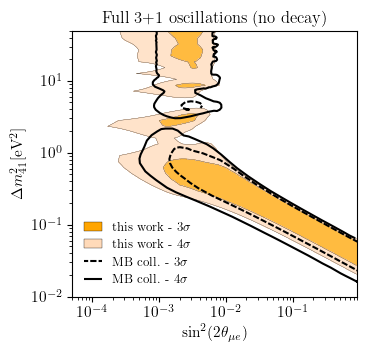

In [16]:
fig, ax = make_sin2thetaemu_plot_comparison(dic_numu_MC_keep_numu_norm, name='numu_MC_keep_numu_norm')

x,y=np.genfromtxt('MiniTools/include/MB_data_release_2022/miniboone_fit_3sigma_1.dat', unpack=True)
x,y=pt.get_ordered_closed_region([x,y], logx=True, logy=True)
ax.plot(x,y, color='black', ls=(1,(3,1)))

x,y=np.genfromtxt('MiniTools/include/MB_data_release_2022/miniboone_fit_3sigma_2.dat', unpack=True)
x,y=pt.get_ordered_closed_region([x,y], logx=True, logy=True)
ax.plot(x,y, color='black', ls=(1,(3,1)), label=r'MB coll. - $3\sigma$')


x,y=np.genfromtxt('MiniTools/include/MB_data_release_2022/miniboone_fit_4sigma_1.dat', unpack=True)
x,y=pt.get_ordered_closed_region([x,y], logx=True, logy=True)
ax.plot(x,y, color='black', ls=(1,(3,0)))

x,y=np.genfromtxt('MiniTools/include/MB_data_release_2022/miniboone_fit_4sigma_2.dat', unpack=True)
x,y=pt.get_ordered_closed_region([x,y], logx=True, logy=True)
ax.plot(x,y, color='black', ls=(1,(3,0)), label=r'MB coll. - $4\sigma$')

ax.set_xlim(0.5e-4,0.9)
ax.set_ylim(1e-2,50)
ax.legend(loc='lower left', fontsize=9, handlelength=1.5)
ax.set_title(r'Full 3+1 oscillations (no decay)')
fig.savefig(f"{micro.path_plots}/MH_full_osc_sin2thetaemuSQR_profiled_comparison.pdf", dpi=300)

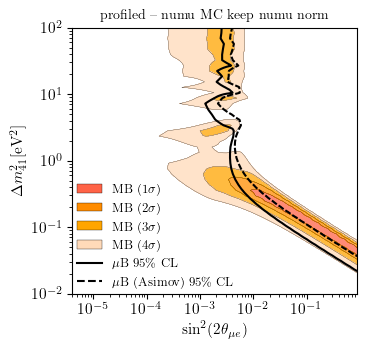

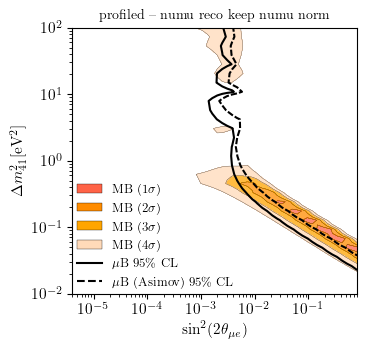

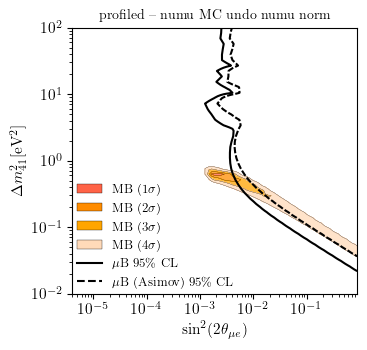

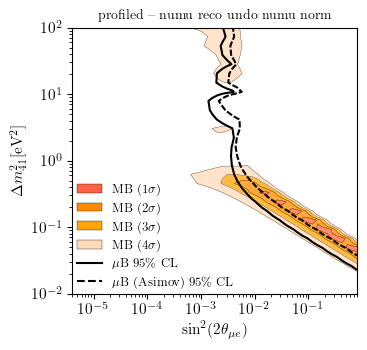

In [17]:
# make_sin2thetaemu_plot(dic_app, name='app_only')
make_sin2thetaemu_plot(dic_numu_MC_keep_numu_norm, name='numu_MC_keep_numu_norm')
make_sin2thetaemu_plot(dic_numu_reco_keep_numu_norm, name='numu_reco_keep_numu_norm')
make_sin2thetaemu_plot(dic_numu_MC_undo_numu_norm, name='numu_MC_undo_numu_norm')
make_sin2thetaemu_plot(dic_numu_reco_undo_numu_norm, name='numu_reco_undo_numu_norm')

### Ue4 vs dm4 (profile over Umu4)

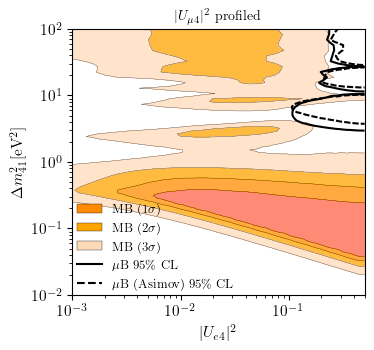

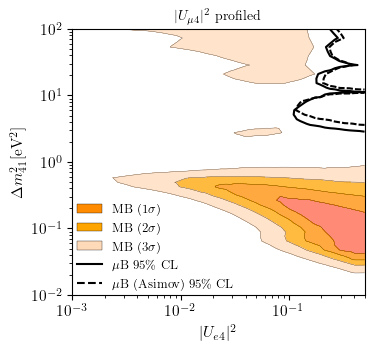

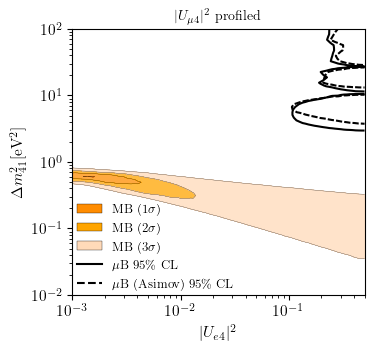

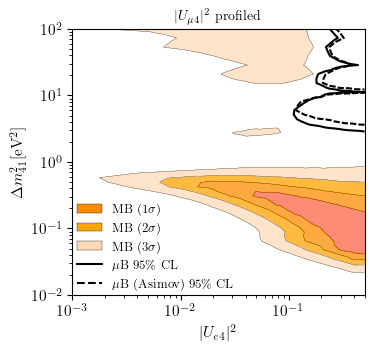

In [21]:
filenames = ['MH_numu_MC_keep_numu_norm', 'MH_numu_reco_keep_numu_norm','MH_numu_MC_undo_numu_norm', 'MH_numu_reco_undo_numu_norm']

for filename in filenames:
    data = param_scan.pickle_read(f"fit_data/fits_before_May6/{filename}.pkl")

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 

    MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
    MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
    MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

    Ue4SQR, Umu4SQR, dm4SQR = data[:,2], data[:,3], data[:,1]**2
    sin2theta = 4*Ue4SQR*Umu4SQR

    # Profile each chi2
    prof_x, prof_y, prof_MiniApp_deltachi2 = param_scan.profile_in_plane(Ue4SQR, dm4SQR, MiniApp_deltachi2)
    prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2 = param_scan.profile_in_plane(Ue4SQR, dm4SQR, MicroApp_deltachi2)
    prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2 = param_scan.profile_in_plane(Ue4SQR, dm4SQR, MicroApp_Asimov_deltachi2)

    fig, ax1 = pt.std_fig(figsize=(3.7, 3.5), ax_form=pt.std_axes_form)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$|U_{e 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(fr"$|U_{{\mu 4}}|^2$ profiled", fontsize=10)
    # ax1.set_title(fr"$|U_{{\mu 4}}|^2$ profiled -- " + filename[3:].replace('_',' '), fontsize=10)

    le = len(np.unique(Ue4SQR))
    kwargs_interp = {'fine_gridx': le*2,  
                            'fine_gridy': le*2, 
                            'logx':True, 
                            'logy':True,
                            }

    X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MiniApp_deltachi2, **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0]+levels_sigmas_2dof, colors=['tomato','darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=levels_sigmas_2dof, colors=['black','black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

    X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MicroApp_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MicroApp_Asimov_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

    ax1.legend(loc=(0,0), fontsize=9)
    fig.savefig(f"{micro.path_plots}/{filename}_ue4_profiled.pdf", dpi=300)

### Umu4 vs dm4 (profile over Ue4)

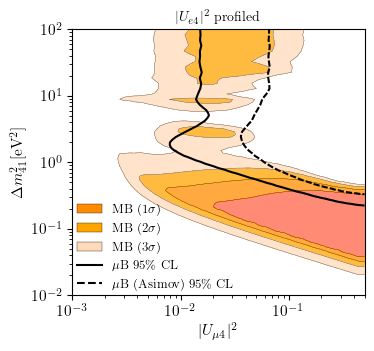

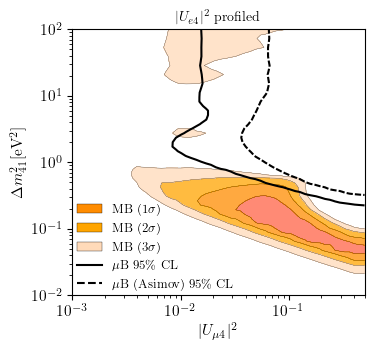

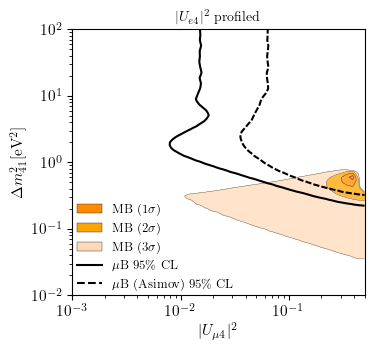

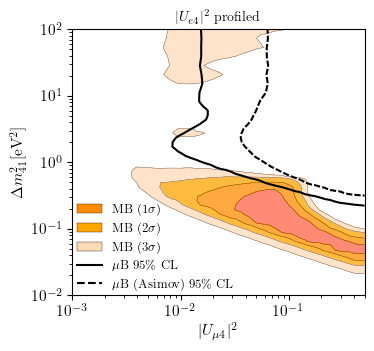

In [22]:
filenames = ['MH_numu_MC_keep_numu_norm', 'MH_numu_reco_keep_numu_norm','MH_numu_MC_undo_numu_norm', 'MH_numu_reco_undo_numu_norm']
for filename in filenames:
    data = param_scan.pickle_read(f"fit_data/fits_before_May6/{filename}.pkl")

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 

    
    MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
    MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
    MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

    Ue4SQR, Umu4SQR, dm4SQR = data[:,2], data[:,3], data[:,1]**2

    # Profile each chi2
    prof_x, prof_y, prof_MiniApp_deltachi2 = param_scan.profile_in_plane(Umu4SQR, dm4SQR, MiniApp_deltachi2)
    prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2 = param_scan.profile_in_plane(Umu4SQR, dm4SQR, MicroApp_deltachi2)
    prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2 = param_scan.profile_in_plane(Umu4SQR, dm4SQR, MicroApp_Asimov_deltachi2)

    fig, ax1 = pt.std_fig(figsize=(3.7, 3.5), ax_form=pt.std_axes_form)
    xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.axis([xmin, xmax, ymin, ymax])
    # ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
    # ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(fr"$|U_{{e 4}}|^2$ profiled", fontsize=10)
    # ax1.set_title(fr"$|U_{{e 4}}|^2$ profiled -- " + filename[3:].replace('_',' '), fontsize=10)

    le = len(np.unique(Ue4SQR))
    kwargs_interp = {'fine_gridx': le*2,  
                            'fine_gridy': le*2, 
                            'logx':True, 
                            'logy':True,
                            }

    X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MiniApp_deltachi2, **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0]+levels_sigmas_2dof, colors=['tomato','darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=levels_sigmas_2dof, colors=['black','black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

    X, Y, Z = pt.interp_grid(prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

    ax1.legend(loc=(0,0), fontsize=9)
    fig.savefig(f"{micro.path_plots}/{filename}_umu4_profiled.pdf", dpi=300)

### 3D scan full oscillation (slices)

In [25]:
labels_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
string_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
def get_var(data, i):
    if i == 1:
        return data[:,1]**2
    return data[:,i]

def plot_all_slices(filename, xi=2, yi=3, zi=1, global_deltachi2=False):
    data = param_scan.pickle_read(f"fit_data/fits_before_May6/{filename}.pkl")   
    
    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
    MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
    MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

    x, y, z = get_var(data,xi), get_var(data,yi), get_var(data,zi)
    i_min = np.argmin(MiniApp_deltachi2)
    x_min, y_min, z_min = x[i_min], y[i_min], z[i_min]
    
    z_slices = np.geomspace(np.min(z), np.max(z),9,endpoint=True)
    if z_min not in z_slices:
        z_slices = np.delete(z_slices, np.argmin(np.abs(z_slices - z_min)))
        z_slices = np.append(z_slices, z_min)
    z_slices = np.sort(z_slices)
    
    fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharex=False, sharey=False, constrained_layout=False)
    plt.subplots_adjust(hspace=0.075, wspace=0.05)
    axs = axs.flatten()
    for i, z_slice in enumerate(z_slices):
        z_slice_true = z[np.argmin(np.abs(z - z_slice))]
        cut = (z == z_slice_true)


        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on", zorder=10,labelsize=13)

        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())

        if i in [0,3,6]:
            ax.set_ylabel(string_slices[yi], fontproperties=pt.font, fontsize=13)
        else:
            ax.set_yticklabels([])
            
        if i in [6,7,8]:
            ax.set_xlabel(string_slices[xi], fontproperties=pt.font, fontsize=13)
        else:
            ax.set_xticklabels([])

        ax.annotate(text=fr"{string_slices[zi]} $\,= {z_slice_true:.3f}$", 
                    xycoords='axes fraction', 
                    xy=(0.05,0.86), 
                    fontsize=13, 
                    bbox=dict(facecolor='white', edgecolor='None', alpha=0.9, boxstyle='round'))

        kwargs_interp = {   'fine_gridx': len(np.unique(x)),  
                            'fine_gridy': len(np.unique(y)), 
                            'logx':True, 
                            'logy':True,
                            'method': 'triangulation'
                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2), **kwargs_interp)
            MB_levels = levels_sigmas_3dof
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2[cut]), **kwargs_interp)
            MB_levels = levels_sigmas_2dof
        
        cs = ax.contourf(X,Y,Z, levels=[0]+MB_levels, colors=['tomato','darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
        cs = ax.contour(X,Y,Z, levels=MB_levels, colors=['black','black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)
        ax.scatter(X.flatten()[np.argmin(Z)], Y.flatten()[np.argmin(Z)], marker='*', facecolor='white', edgecolor='black', lw=0.5, zorder=10)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2), **kwargs_interp)
            level_MicroBooNE = level_95CL_3dof
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2[cut]), **kwargs_interp)
            level_MicroBooNE = level_95CL_2dof
        cs = ax.contour(X,Y,Z, levels=level_MicroBooNE, colors=['black'], zorder=2)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2[cut]), **kwargs_interp)
        cs = ax.contour(X,Y,Z, levels=level_MicroBooNE, colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        if z_min == z_slice:
            ax.scatter(x_min, y_min, marker='*', facecolor='black', edgecolor='black', lw=0.25, zorder=10)
        if i == 0:
            ax.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
            ax.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
            ax.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
            ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
            ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')
            ax.legend(loc=(0,0), fontsize=9)
    
    # ndof = r' $\vert$ $n_{\rm dof} = 2$' if global_deltachi2 else r' $\vert$ $n_{\rm dof} = 2$'
    fig.savefig(f"{micro.path_plots}/MH_fullosc_allslices_{xi}_{yi}_{zi}{'_global' if global_deltachi2 else ''}.pdf", bbox_inches='tight', dpi=300)



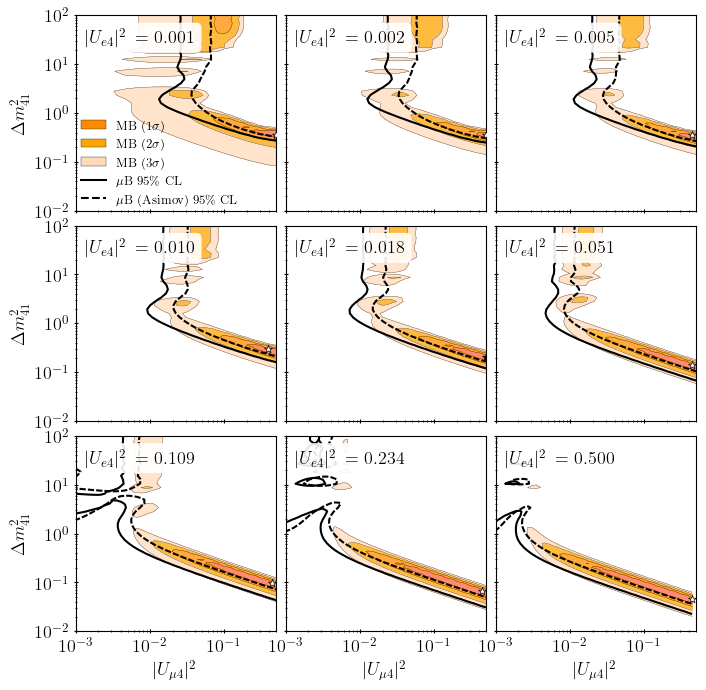

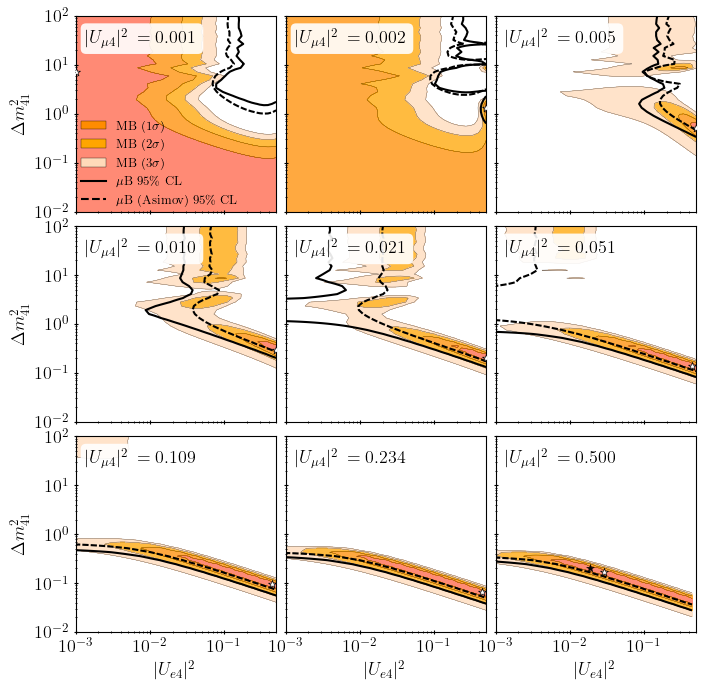

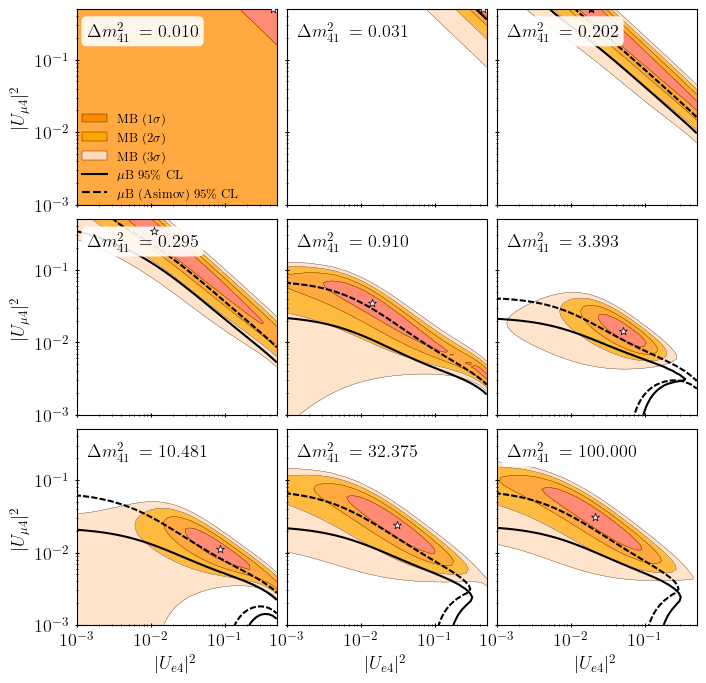

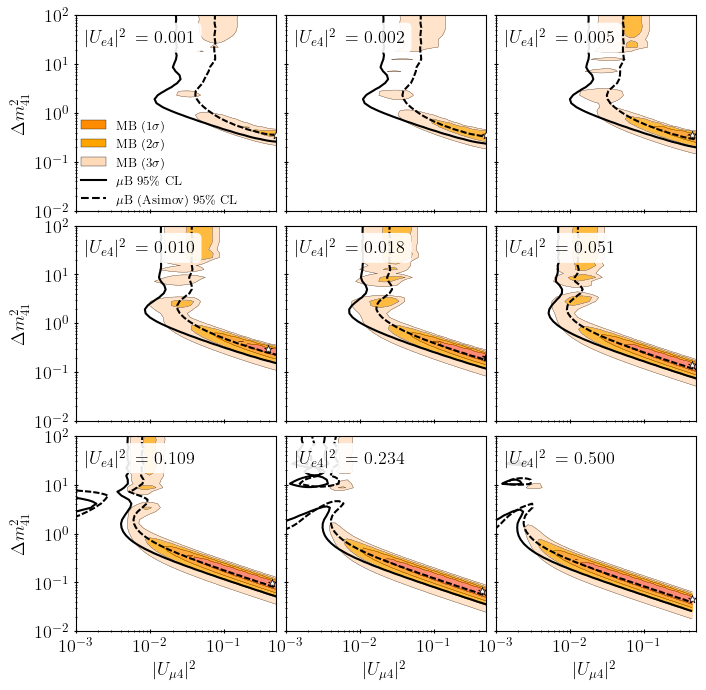

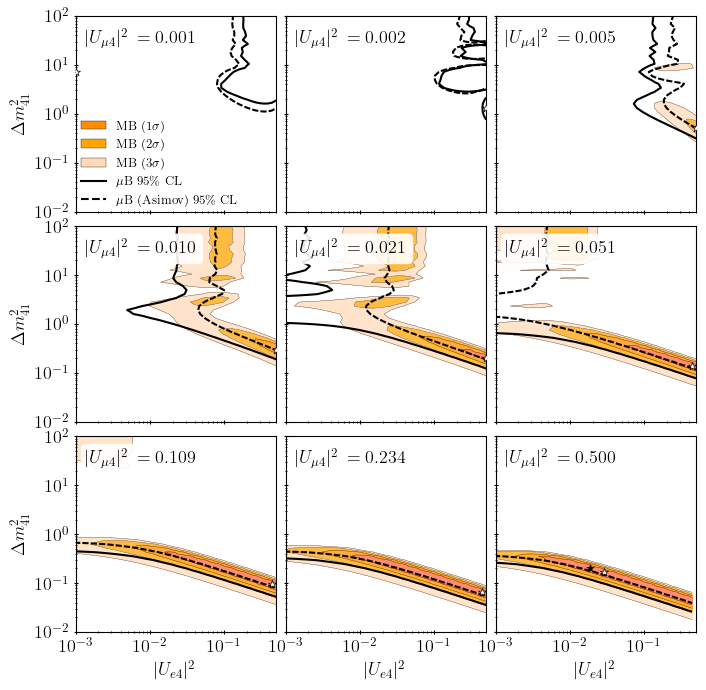

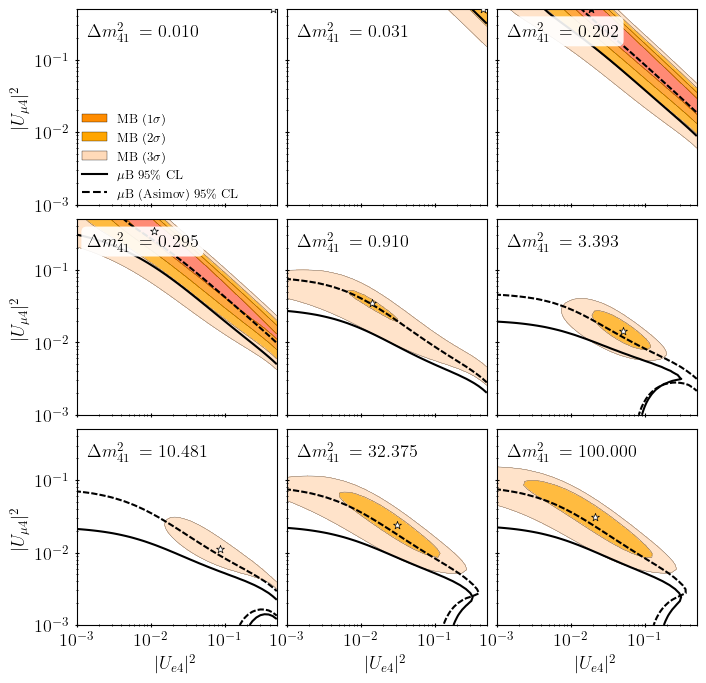

In [26]:
plot_all_slices('MH_numu_MC_keep_numu_norm', xi=3, yi=1, zi=2)
plot_all_slices('MH_numu_MC_keep_numu_norm', xi=2, yi=1, zi=3)
plot_all_slices('MH_numu_MC_keep_numu_norm', xi=2, yi=3, zi=1)

plot_all_slices('MH_numu_MC_keep_numu_norm', xi=3, yi=1, zi=2, global_deltachi2=True)
plot_all_slices('MH_numu_MC_keep_numu_norm', xi=2, yi=1, zi=3, global_deltachi2=True)
plot_all_slices('MH_numu_MC_keep_numu_norm', xi=2, yi=3, zi=1, global_deltachi2=True)